# Wasserstein Generative Adversarial Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model

tf.random.set_seed(0)

Este módulo implementa una arquitectura avanzada de Red Generativa Adversarial basada
en la distancia de Wasserstein con penalización de gradiente, que proporciona mayor
estabilidad de entrenamiento y convergencia más robusta comparada con GAN tradicionales.
La implementación incluye un generador convolucional transpuesto y un crítico (discriminador)
que evalúa la distancia de Wasserstein entre distribuciones de datos reales y sintéticos.

**Fundamentos teóricos**

La implementación se basa en los principios de WGAN-GP (Gulrajani et al., 2017) que
resuelve problemas de inestabilidad en el entrenamiento adversarial mediante:
1. Uso de distancia de Wasserstein en lugar de divergencia Jensen-Shannon
2. Penalización de gradiente para enforcar condición de Lipschitz
3. Eliminación de clipping de pesos por regularización diferenciable

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(28, 28, 1)):
    """
    Visualiza un conjunto de imágenes almacenadas en tensor mediante representación
    en cuadrícula uniforme 5×5 utilizando matplotlib.
    """

    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.numpy()
    image_grid = np.zeros((size[0]*5, size[1]*5, size[2]))

    for i in range(5):
        for j in range(5):
            if i*5 + j < num_images:
                img = image_unflat[i*5 + j]
                image_grid[i*size[0]:(i+1)*size[0], j*size[1]:(j+1)*size[1]] = img

    plt.imshow(image_grid.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
def build_generator(z_dim=64):
    """
    Construye el modelo generador utilizando arquitectura convolucional transpuesta
    optimizada para síntesis de dígitos MNIST.

    Esta función implementa un generador profundo basado en la arquitectura DCGAN
    adaptada para WGAN-GP, que transforma vectores de ruido latente de 64 dimensiones
    en imágenes sintéticas de 28×28 píxeles. El diseño emplea convoluciones transpuestas
    con normalización por lotes y activaciones LeakyReLU para generar imágenes de
    alta calidad con diversidad estocástica controlada.

    Parámetros:
    -----------
    z_dim : int, opcional (default=64)
        Dimensionalidad del espacio latente de entrada. Define la capacidad
        expresiva del generador y la diversidad potencial de imágenes generadas.
        Valor típico: 64-128 dimensiones para MNIST.

    Retorna:
    --------
    tf.keras.Model
        Modelo generador compilado con:
        - Entrada: vector de ruido (z_dim,)
        - Salida: imagen sintética (28, 28, 1) con activación tanh
        - Arquitectura: 4 capas principales con upsampling progresivo
    """

    input_noise = Input(shape=(z_dim,))

    # Reshape y proyecto
    x = layers.Dense(7*7*256, use_bias=False)(input_noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 256))(x)

    # Bloques de transposed convolution
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    # Capa final
    output_img = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                       use_bias=False, activation='tanh')(x)

    return Model(input_noise, output_img)

In [ ]:
def build_critic():
    """
    Construye el modelo crítico (discriminador) para evaluación de distancia
    de Wasserstein en el marco WGAN-GP.

    Retorna:
    --------
    tf.keras.Model
        Modelo crítico compilado con:
        - Entrada: imagen (28, 28, 1)
        - Salida: puntuación escalar (sin activación)
        - Arquitectura: 2 capas convolucionales + clasificador lineal
    """
    input_img = Input(shape=(28, 28, 1))

    # Bloques de convolución
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_img)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(input_img)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)  # Salida lineal (sin activación)

    return Model(input_img, x)

In [ ]:
def get_noise(n_samples, z_dim):
    """
    Genera vectores de ruido aleatorio del espacio latente para alimentar
    el generador WGAN-GP.

    Esta función utilitaria produce muestras aleatorias independientes de una
    distribución normal estándar multivariada, proporcionando la diversidad
    estocástica fundamental para la generación de imágenes variadas. La
    implementación utiliza el generador de números aleatorios de TensorFlow
    para compatibilidad con diferenciación automática y ejecución en GPU.

    Parámetros:
    -----------
    n_samples : int
        Número de vectores de ruido a generar, típicamente igual al batch_size
        durante entrenamiento o al número deseado de imágenes sintéticas.

    z_dim : int
        Dimensionalidad del espacio latente, debe coincidir con la entrada
        esperada por el generador (típicamente 64 dimensiones para MNIST).

    Retorna:
    --------
    tf.Tensor
        Tensor de ruido con forma (n_samples, z_dim) y distribución N(0, I).
        Cada fila representa un vector latente independiente para generación.
    """

    return tf.random.normal([n_samples, z_dim])

Algoritmo de penalización:
--------------------------
1. **Interpolación lineal**:
   x̂ = ε·x_real + (1-ε)·x_fake, donde ε ~ U(0,1)

2. **Evaluación del crítico**:
   Cálculo de puntuaciones para imágenes interpoladas

3. **Cálculo de gradientes**:
   ∇_x̂ C(x̂) mediante diferenciación automática

4. **Norma L2 del gradiente**:
   ||∇_x̂ C(x̂)||_2 para cada muestra del lote

5. **Penalización cuadrática**:
   GP = E[(||∇_x̂ C(x̂)||_2 - 1)²]

Fundamento teórico:
-------------------
La penalización de gradiente enforza la condición de 1-Lipschitz:
|C(x₁) - C(x₂)| ≤ ||x₁ - x₂||₂ para todo x₁, x₂

Esto garantiza:
- Convergencia teórica del algoritmo WGAN
- Estabilidad de entrenamiento sin clipping de pesos
- Gradientes informativos para el generador
- Eliminación de problemas de vanishing/exploding gradients

Ventajas sobre clipping de pesos:
- Penalización diferenciable (compatible con backpropagation)
- No restringe la capacidad expresiva del crítico
- Convergencia más rápida y estable
- Mejor calidad de imágenes generadas

In [ ]:
def gradient_penalty(critic, real_images, fake_images, batch_size):
    """
    Calcula la penalización de gradiente para enforcar la condición de Lipschitz
    en el crítico WGAN-GP.

    Esta función implementa el componente central de WGAN-GP que reemplaza el
    clipping de pesos por una penalización diferenciable basada en la norma
    del gradiente. La técnica interpola linealmente entre imágenes reales y
    sintéticas, calculando la penalización cuando la norma del gradiente se
    desvía de 1, garantizando que el crítico satisfaga la condición de Lipschitz
    necesaria para la convergencia teórica de WGAN.

    Parámetros:
    -----------
    critic : tf.keras.Model
        Modelo crítico entrenado que evalúa imágenes y produce puntuaciones.

    real_images : tf.Tensor
        Lote de imágenes reales del conjunto de datos con forma (batch_size, 28, 28, 1).

    fake_images : tf.Tensor
        Lote de imágenes sintéticas generadas con la misma forma que real_images.

    batch_size : int
        Tamaño del lote actual, utilizado para generar coeficientes de interpolación.

    Retorna:
    --------
    tf.Tensor
        Valor escalar de la penalización de gradiente, listo para incorporación
        en la función de pérdida del crítico.
    """
    # Mezcla de imágenes reales y falsas
    epsilon = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        # Calcula las puntuaciones del crítico para las imágenes interpoladas
        crit_interpolated = critic(interpolated_images)

    # Calcula el gradiente de las puntuaciones respecto a las imágenes interpoladas
    gradients = tape.gradient(crit_interpolated, interpolated_images)

    # Calcula la norma L2 del gradiente
    gradients_sqr = tf.square(gradients)
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = tf.sqrt(gradients_sqr_sum)

    # Penalización: diferencia cuadrática de la norma del gradiente respecto a 1
    gradient_penalty = tf.reduce_mean(tf.square(gradient_l2_norm - 1))

    return gradient_penalty

In [ ]:
def generator_loss(fake_output):
    """
    Calcula la función de pérdida del generador en el marco WGAN-GP.

    Esta función implementa la pérdida adversarial del generador basada en
    la distancia de Wasserstein, cuyo objetivo es maximizar las puntuaciones
    del crítico para imágenes sintéticas. A diferencia de GAN tradicionales
    que minimizan entropía cruzada binaria, WGAN-GP maximiza directamente
    la puntuación promedio del crítico, proporcionando gradientes más
    informativos y entrenamiento más estable.

    Parámetros:
    -----------
    fake_output : tf.Tensor
        Puntuaciones del crítico para imágenes sintéticas con forma (batch_size, 1).
        Valores altos indican que el crítico considera las imágenes como reales.

    Retorna:
    --------
    tf.Tensor
        Pérdida del generador como valor escalar negativo de la puntuación promedio.

    Fundamento matemático:
    ----------------------
    L_G = -E_{z~p_z}[C(G(z))]

    Donde:
    - G(z): imágenes generadas a partir de ruido z
    - C(G(z)): puntuación del crítico para imágenes sintéticas
    - Minimizar L_G equivale a maximizar E[C(G(z))]

    Interpretación:
    - Pérdida baja → crítico asigna puntuaciones altas a imágenes sintéticas
    - Pérdida alta → crítico detecta fácilmente imágenes sintéticas
    - Objetivo: Engañar al crítico para obtener puntuaciones similares a datos reales
    """
    '''
    Pérdida del generador: maximizar las puntuaciones del crítico para imágenes falsas
    '''
    return -tf.reduce_mean(fake_output)


def critic_loss(real_output, fake_output, gp, c_lambda):
    """
    Calcula la función de pérdida del crítico en el marco WGAN-GP incluyendo
    penalización de gradiente.

    Esta función implementa la pérdida completa del crítico que combina la
    aproximación de distancia de Wasserstein con la penalización de gradiente
    para enforcar la condición de Lipschitz. La formulación busca maximizar
    la diferencia entre puntuaciones de datos reales y sintéticos mientras
    penaliza desviaciones de la norma unitaria del gradiente.

    Parámetros:
    -----------
    real_output : tf.Tensor
        Puntuaciones del crítico para imágenes reales con forma (batch_size, 1).

    fake_output : tf.Tensor
        Puntuaciones del crítico para imágenes sintéticas con forma (batch_size, 1).

    gp : tf.Tensor
        Valor de penalización de gradiente calculado mediante gradient_penalty().

    c_lambda : float
        Hiperparámetro de ponderación para la penalización de gradiente.
        Valor típico: 10 (según paper original WGAN-GP).

    Retorna:
    --------
    tf.Tensor
        Pérdida total del crítico como valor escalar.

    Fundamento matemático:
    ----------------------
    L_C = E_{x~p_fake}[C(x)] - E_{x~p_real}[C(x)] + λ·E[(||∇_x̂ C(x̂)||_2 - 1)²]

    Componentes:
    1. **Término Wasserstein**: E[C(fake)] - E[C(real)]
       - Maximiza diferencia entre puntuaciones reales y sintéticas
       - Aproxima distancia de Wasserstein entre distribuciones

    2. **Penalización de gradiente**: λ·GP
       - Enforza condición de 1-Lipschitz
       - Garantiza convergencia teórica
       - Previene gradientes explosivos/desvanecientes

    Interpretación de pérdida:
    - Pérdida baja → crítico distingue bien entre real/sintético con gradientes estables
    - Pérdida alta → crítico confundido o gradientes inestables
    - Equilibrio → crítico proporciona gradientes informativos al generador
    """
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + c_lambda * gp

In [ ]:
@tf.function
def train_step(real_images):
    """
    Ejecuta un paso completo de entrenamiento WGAN-GP con múltiples actualizaciones
    del crítico por actualización del generador.

    Esta función implementa el algoritmo de entrenamiento WGAN-GP que alterna
    entre múltiples actualizaciones del crítico (para mejor aproximación de
    distancia Wasserstein) y una actualización del generador. La decoración
    @tf.function compila la función en un grafo computacional optimizado para
    ejecución eficiente en GPU/TPU.

    Parámetros:
    -----------
    real_images : tf.Tensor
        Lote de imágenes reales del conjunto MNIST con forma (batch_size, 28, 28, 1)
        y valores normalizados en rango [-1, 1].

    Retorna:
    --------
    tuple
        Tupla conteniendo:
        - gen_loss: Pérdida del generador en la iteración actual
        - mean_critic_loss: Pérdida promedio del crítico sobre múltiples actualizaciones

    Algoritmo de entrenamiento:
    ---------------------------
    1. **Fase del crítico** (repetida crit_repeats=5 veces):
       - Generación de imágenes sintéticas G(z)
       - Evaluación de puntuaciones C(x_real) y C(G(z))
       - Cálculo de penalización de gradiente GP
       - Cálculo de pérdida del crítico L_C
       - Actualización de parámetros del crítico

    2. **Fase del generador** (una vez por paso):
       - Generación de nuevas imágenes sintéticas
       - Evaluación de puntuaciones del crítico
       - Cálculo de pérdida del generador L_G
       - Actualización de parámetros del generador
    """
    batch_size = tf.shape(real_images)[0]

    mean_critic_loss = 0

    # Actualizar crítico múltiples veces
    for _ in range(crit_repeats):
        with tf.GradientTape() as critic_tape:
            # Generar imágenes falsas
            noise = get_noise(batch_size, z_dim)
            fake_images = generator(noise, training=True)

            # Obtener puntuaciones del crítico
            real_output = critic(real_images, training=True)
            fake_output = critic(fake_images, training=True)

            # Calcular penalización de gradiente
            gp = gradient_penalty(critic, real_images, fake_images, batch_size)

            # Calcular pérdida del crítico
            crit_loss = critic_loss(real_output, fake_output, gp, c_lambda)

        # Calcular y aplicar gradientes
        gradients_of_critic = critic_tape.gradient(crit_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(gradients_of_critic, critic.trainable_variables))

        mean_critic_loss += crit_loss / crit_repeats

    # Actualizar generador
    with tf.GradientTape() as gen_tape:
        noise = get_noise(batch_size, z_dim)
        fake_images = generator(noise, training=True)
        fake_output = critic(fake_images, training=True)
        gen_loss = generator_loss(fake_output)

    # Calcular y aplicar gradientes
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, mean_critic_loss

In [ ]:
# Hiperparámetros
n_epochs = 2        # Número de épocas de entrenamiento
z_dim = 64            # Dimensionalidad del espacio latente
display_step = 50     # Intervalo de épocas para visualización
batch_size = 128      # Tamaño de lote para entrenamiento
lr = 0.0002           # Tasa de aprendizaje para optimizadores Adam
beta_1 = 0.5          # Coeficiente de momento de primer orden (Adam)
beta_2 = 0.999        # Coeficiente de momento de segundo orden (Adam)
c_lambda = 10         # Ponderación de penalización de gradiente
crit_repeats = 5      # Número de actualizaciones del crítico por actualización del generador

# Cargar y preparar datos MNIST
(train_images, _), (_, _) = mnist.load_data()
train_images = (train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(len(train_images)).batch(batch_size)

# Construir modelos
generator = build_generator(z_dim)
critic = build_critic()

# Optimizadores
generator_optimizer = keras.optimizers.Adam(lr, beta_1, beta_2)
critic_optimizer = keras.optimizers.Adam(lr, beta_1, beta_2)

# Historial de pérdidas
generator_losses = []
critic_losses = []

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0: Generator loss: -9.862811088562012, Critic loss: -1.3438138961791992


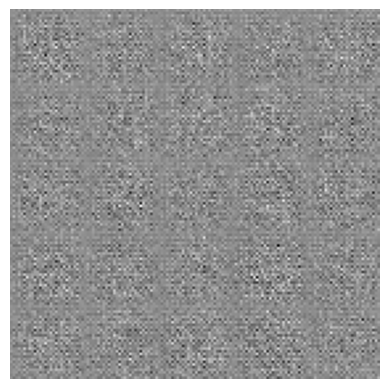

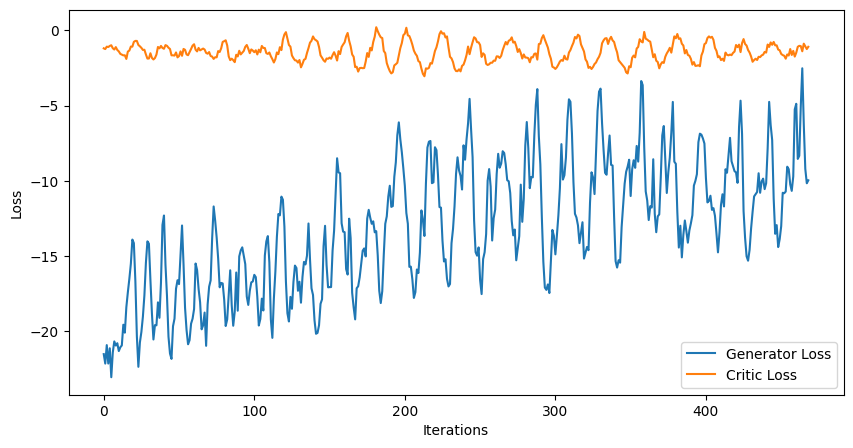

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# Bucle de entrenamiento
for epoch in range(n_epochs):
    for batch in tqdm(train_dataset):
        gen_loss, crit_loss = train_step(batch)

        generator_losses.append(gen_loss.numpy())
        critic_losses.append(crit_loss.numpy())

    # Visualización
    if epoch % display_step == 0:
        print(f"Epoch {epoch}: Generator loss: {np.mean(generator_losses[-display_step:])}, "
              f"Critic loss: {np.mean(critic_losses[-display_step:])}")

        # Generar y mostrar imágenes de muestra
        noise = get_noise(25, z_dim)
        generated_images = generator(noise, training=False)
        show_tensor_images(generated_images)

        # Graficar pérdidas
        plt.figure(figsize=(10, 5))
        plt.plot(generator_losses, label='Generator Loss')
        plt.plot(critic_losses, label='Critic Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Bucle principal de entrenamiento WGAN-GP con monitoreo de progreso y visualización.

Estructura del entrenamiento:
-----------------------------
1. **Iteración por épocas**: 100 épocas completas sobre dataset MNIST
2. **Procesamiento por lotes**: ~469 lotes de 128 imágenes por época  
3. **Actualización adversarial**: train_step() por cada lote
4. **Registro de métricas**: Almacenamiento de pérdidas para análisis
5. **Visualización periódica**: Cada 50 épocas muestra progreso

Monitoreo de progreso:
----------------------
- **Pérdidas promedio**: Cálculo sobre últimas display_step épocas
- **Muestras generadas**: 25 imágenes sintéticas en cuadrícula 5×5
- **Gráficas de convergencia**: Evolución temporal de pérdidas
- **Progreso visual**: Mejora cualitativa en imágenes generadas

Métricas de evaluación:
-----------------------
- **Generator Loss**: Capacidad para engañar al crítico (objetivo: minimizar)
- **Critic Loss**: Capacidad discriminativa + penalización GP (objetivo: minimizar)
- **Balance adversarial**: Relación entre pérdidas indica estabilidad
- **Calidad visual**: Evaluación subjetiva de realismo y diversidad

Indicadores de convergencia exitosa:
- Pérdidas estabilizadas sin oscilaciones extremas
- Imágenes generadas visualmente similares a MNIST real
- Diversidad en dígitos generados (sin colapso de modo)
- Gradientes estables sin explosión/desvanecimiento

El entrenamiento completo toma aproximadamente 2-4 horas en GPU moderna,
produciendo un generador capaz de sintetizar dígitos MNIST de alta calidad
con diversidad controlada mediante muestreo del espacio latente.